## 算式识别
- 总体概论


## 步骤0
### 导入数据集

label:
['(0+0)+9=9' '9*8+6=78' '1+7+0=8' '5+4+9=18' '7-(1*7)=0']
name of images:
['train/0.jpg' 'train/1.jpg' 'train/2.jpg' 'train/3.jpg' 'train/4.jpg']
数据集共有图片：100000
(64, 300, 3)


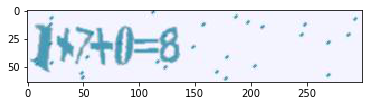

In [2]:
import pandas as pd
from sklearn.datasets import load_files 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

 # 加载标签数据
labels_file = pd.read_csv('train.csv')
label = np.array(labels_file['label'])
file_names = np.array(labels_file['filename'])

# 显示数据结构
print('label:')
print(label[:5])
print('name of images:')
print(file_names[:5])
print('数据集共有图片：%d' % len(file_names))

# 展示图片sample
img = Image.open('train/2.jpg')
print(np.array(img).shape)
plt.imshow(img)
plt.show()

In [2]:
from tqdm import tqdm

# 用PIL进行图片加载，并转换为灰度格式 
def covert_store_gray_img(img_path, store_path):
    '''read images to destination, covert to gray'''
    img = Image.open(img_path).convert('L')
    img.save(store_path)
    return img

# img = covert_store_gray_img('train/0.jpg', '0000.jpg')
# print(np.array(img))

# 设置转换灰度图片的地址到‘covert/’
destination_path = ['covert' + file_name[5:] for file_name in file_names]

# 将所有图片转化层灰度图片到目标文件夹
# all_images = [covert_store_gray_img(file_names[i], destination_path[i]) for i in range(len(file_names))]

# 将图片转化为数组
def img_to_array(img_path):
    img = Image.open(img_path)
    return np.expand_dims(np.array(img.getdata()).reshape(64, 300).astype('float32') / 255, axis=2)

# 所有图片批量转化为数组
def all_to_array(img_paths):
    list_of_tensors = [img_to_array(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)









# 将所有训练数据储存在train_data中
# train_data = all_to_array(destination_path)

In [3]:
img_to_array('covert/0.jpg')

array([[[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       ..., 
       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]]], dtype=float32)

## 步骤2

## 构建模型

In [4]:
# 用课堂方法构建模型
from keras.engine.topology import Input
from keras.models import *
from keras.layers import *

sequence = ['+-*()1234567890']

# 构架CNN
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(64, 300, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru1'))
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru1b'))
model.merge([gru1, gru1b], mode='sum')
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru2'))
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru2b'))
model.merge(gru2, gru2b, mode='concat')
model.add(Dropout(.2))
model.summary()

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, name="gru1", return_sequences=True, kernel_initializer="he_normal")`


ValueError: Input 0 is incompatible with layer gru1: expected ndim=3, found ndim=4

In [1]:
# 用论文方法构建模型

from keras.engine.topology import Input
from keras.models import *
from keras.layers import *

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :] 测试感觉没影响
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

input_tensor = Input(shape=(64, 300, 1))
# 
x = input_tensor

x = Conv2D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
# x = Conv2D(filters=256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=2, strides=2, padding='same', activation='relu')(x)

x = BatchNormalization()(x)
x = Conv2D(filters=512, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(1, 2))(x)
x = Conv2D(filters=512, kernel_size=2, strides=2, padding='same', activation='relu')(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
# 连接CNN和RNN的层
x = Dense(15, activation='relu')(x)
# print(x.shape)
gru_1 = GRU(128, return_sequences=True, name='gru_1')(x)
gru_1b = GRU(128, return_sequences=True, go_backwards=True, name='gru_1b')(x)

gru_1_merged = Add()([gru_1, gru_1b])


gru_2 = GRU(128, return_sequences=True, name='gru_2')(gru_1_merged)
gru_2b = GRU(128, return_sequences=True, go_backwards=True, name='gru_2b')(gru_1_merged)

x = Concatenate()([gru_2, gru_2b])

x = Dropout(.2)(x)
x = Dense(15, activation='softmax')(x)

# model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[15], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')
model.summary()
# print(x.shape)
# x.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 300, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 150, 64)  320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 75, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 38, 128)   32896       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [2]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

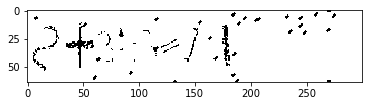

1
2
3
4
5
6
1
2
3
4
5
6
1
2
3
4
5
6
1
2
3
1
2
3
1
2
3
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4

TypeError: binary_img() missing 1 required positional argument: 'threshold'

In [40]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
np.set_printoptions(threshold=np.inf) 

img = Image.open('covert/1589.jpg')
img_data = np.array(img)

# 二值化
def binary_img(img_data, threshold, pattern='plt'):
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            if img_data[i][j] > threshold:
                img_data[i][j] = 255
            else:
                img_data[i][j] = 0
    img = Image.fromarray(img_data)
    if pattern == 'plt':
        plt.imshow(img, cmap='gray')
        plt.show()
    elif pattern == 'PIL':
        img.show()
    return img_data
            
# binary_img(180)
# binary_img(220)
# binary_img(220,'PIL')

# 清楚噪点
def clear_noise(img_data):
    counter = 0
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            if img_data[i][j] == 0:
#                 print('--')
                for k in [-2,-1, 0, 1, 2]:
                    for m in [-2,-1, 0, 1, 2]:
                        if (i+k) < (img_data.shape[0]) & (j+m) < (img_data.shape[1]):
                            if img_data[i+k][j+m] == 0:
                                
                                counter += 1
                                print(counter)
                if counter < 2:
                    img_data[i][j] = 255
                    counter = 0
                counter = 0
    return img_data

# plt.imshow(img, cmap='gray')
# plt.show()
clear_noise_img = clear_noise(binary_img(img_data, 180))
Image.fromarray(clear_noise_img).show()
Image.fromarray(binary_img(180)).show()
# import cv2
# img = binary_img(180, 'PIL')
# h, w = img.shape[:2]
# blured = cv2.blur(img,(5,5)) 
# # print(blured)
# mask = np.zeros((h+2, w+2), np.uint8)
# cv2.floodFill(blured, mask, (w-1,h-1), (255,255,255), (2,2,2),(3,3,3),8)
# cv2.imshow("floodfill", blured)

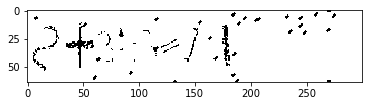

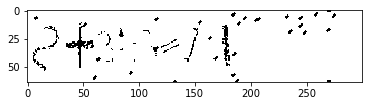

In [3]:
import cv2  
  
img = cv2.imread('train/69.jpg')  
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)  
  
a ,contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
cv2.drawContours(img,contours,-1,(0,0,255),3)  
  
cv2.imshow("img", img)  
cv2.waitKey(0) 
cv2.imshow("binary", binary)  
a,contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
cv2.imshow("binary2", binary) 
cv2.waitKey(0) 

-1

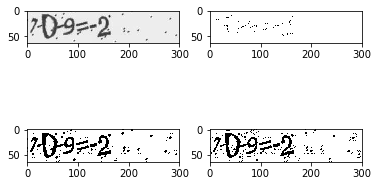

In [12]:
import cv2  
import matplotlib.pyplot as plt  
  
img = cv2.imread('covert/999.jpg',0) #直接读为灰度图像  
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)  
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2) #换行符号 \  
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2) #换行符号 \  
images = [img,th1,th2,th3]  
plt.figure()  
for i in range(4):  
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')  
plt.show() 

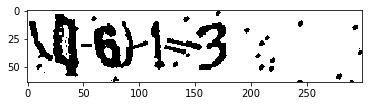

In [50]:
# 自适应二值化
# 模型最后采用该算法
import numpy as np 

import cv2  
from PIL import Image
import matplotlib.pyplot as plt  
img = cv2.imread('covert/96.jpg',0)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,6)
plt.imshow(th2, cmap='gray')
plt.show()
# Image.fromarray(th2).show()
# Image.fromarray(img).show()

# saltImage=saltpepper(th2,0.001)
# plt.imshow(saltImage, cmap='gray')
# plt.show()

原始灰度图


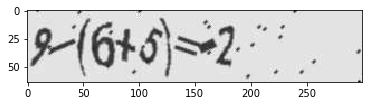

二值化图片


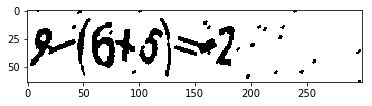

去噪图
用时：2.480883


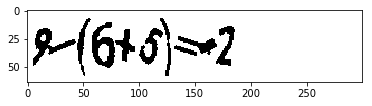

In [4]:
import time

def imshow_ply(img):
    plt.imshow(img, cmap='gray')
    plt.show()

# 二值化
def binary_img(img_data, threshold, pattern='plt'):
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            if img_data[i][j] > threshold:
                img_data[i][j] = 255
            else:
                img_data[i][j] = 0
    img = Image.fromarray(img_data)
    if pattern == 'plt':
        plt.imshow(img, cmap='gray')
        plt.show()
    elif pattern == 'PIL':
        img.show()
    elif pattern == 'off':
        pass
    return img_data

img = Image.open('covert/9631.jpg')
print('原始灰度图')
plt.imshow(img, cmap='gray')
plt.show()
img_data_origin = np.array(img)
img_data = binary_img(img_data_origin, 200, pattern='off')
print('二值化图片')
plt.imshow(img_data, cmap='gray')
plt.show()

def clear_noise_rect(img_data, size_window=5):
    time0 = time.time()
    counter = 0
    flag = 0
    
    # 消除上下边界的噪点
    for p in range(img_data.shape[1]):
        for h in [-2, -1, 0, 1, 2]:
            for q in range(5):
                if img_data[q][p] == 0:
                        img_data[q][p+h] = 255
            for u in [-4,-3,-2,-1, 0]:
                if img_data[63+u][p] == 0:

                        img_data[63+u][p+h] = 255
                        
    # 消除左右边界的噪点
    for w in range(img_data.shape[0]):
        for v in [-2, -1, 0, 1, 2]:
            for n in range(5):
                if img_data[w][n] == 0:
                        img_data[w+v][n] = 255
            for u in [-4,-3,-2,-1, 0]:
                if img_data[w][299+u] == 0:

                        img_data[w+v][299+u] = 255
                        
    # 用矩形框消除中间的噪点
    for i in range(img_data.shape[0] - size_window):
        for j in range(img_data.shape[1] - size_window):
            for m in range(1,size_window):
                if img_data[i][j+m] == 255:
                    counter += 1
                if img_data[i+size_window][j+m] == 255:
                    counter += 1
                if img_data[i+m][j] == 255:
                    counter += 1
                if img_data[i+m][j+size_window] == 255:
                    counter += 1
                for k in range(1, size_window):
                    if img_data[i+m][j+k] == 0:
                        flag = 1
            if img_data[i][j] == 255:
                counter += 1
            if img_data[i+size_window][j] == 255:
                counter += 1
            if img_data[i][j+size_window] == 255:
                counter += 1
            if img_data[i+size_window][j+size_window] == 255:
                counter += 1
            if flag == 1 and counter > 19:
                for t in range(size_window+1):
                    for g in range(size_window+1):
                        img_data[i+t][j+g] = 255
                        counter = 0
                        flag = 0
            counter = 0
            flag = 0
    print('用时：%f'% (time.time()-time0))
    return img_data

print('去噪图')
clear_noise_img = clear_noise_rect(img_data, size_window=5)
# Image.fromarray(clear_noise_img).show()
imshow_ply(clear_noise_img)